# Capstone Project: Impact of Workforce Reductions to Company Performance - Data Storytelling

###### This Jupyter notebook will be exploring the relationship between the data extracted from the SEC EDGAR website for S&P 500 financial companies and stock performance year over year.

Employee Count: Companies are required to submit 10-K filings to the SEC on an annual basis, which provides a description of the business, financial metrics, and also relevant ongoing risks. As part of this filing, the company usually provides a count, sometimes accurate, sometimes estimated, of the number of individuals it currently employs. There is no standard of how this specific data is provided and is relatively freeform. Some companies split it up by region or business, while others provide a simple sentence giving the total. This data was extracted on a best efforts basis.

Stock Price: This data was downloaded using the Tiingo API which provided daily adjusted close prices data. This data was resampled at an annual basis, taking the year end values.

###### Generally, you would expect some correlation between employee count and stock price as firms usually staff up before taking on more business and reduce staff in market downturns or when the business is sufferring. What will be interesting to see if it can be seen as a leading or lagging indicator?

In [1]:
# Import modules.
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
import random
from datetime import datetime
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 10]

In [2]:
# Load datasets.
dfrEmpCount = pd.read_csv("7.2_Data_Storytelling/EmployeeCount_2018.csv", index_col="Symbol").transpose()
dfrStkPrice = pd.read_csv("7.2_Data_Storytelling/StkPrice_2018.csv", index_col="date")
# Load S&P 500 Constituent information since the metadata will be 
dfrConstituents = pd.read_csv("7.2_Data_Storytelling/SPX_Constituents_2019-01-28.csv")

# Convert year into full date so the index is the same as dfrStkPrice.
dfrEmpCount["date"] = dfrEmpCount.index
dfrEmpCount["date"] = dfrEmpCount["date"].apply(str)
dfrEmpCount["date"] = "12/31/" + dfrEmpCount["date"].str.slice(0,4)
dfrEmpCount["date"] = pd.to_datetime(dfrEmpCount["date"])
dfrEmpCount = dfrEmpCount.set_index("date")

dfrStkPrice = dfrStkPrice.rename_axis("Symbol", axis="columns")
dfrStkPrice["date"] = dfrStkPrice.index
dfrStkPrice["date"] = pd.to_datetime(dfrStkPrice["date"])
dfrStkPrice = dfrStkPrice.set_index("date")

# Cutting data to be for the same date interval.
dfrEmpCount = dfrEmpCount["1997-12-31":"12-31-2018"]
dfrStkPrice = dfrStkPrice["1997-12-31":"12-31-2018"]

###### In trying to see a relationship between the employee counts and stock price, viewing it as a bar plot or a histogram, wouldn't make sense. Since we're trying to see if these two quantities are related, the best thing to do is view it as a scatterplot and see what correlation looks like.

In [3]:
# Convert both datasets to percentage change year over year.
dfrEmpCount_pct = dfrEmpCount.pct_change()
dfrStkPrice_pct = dfrStkPrice.pct_change()
print(dfrEmpCount_pct.tail(1))
print(dfrStkPrice_pct.tail(1))

Symbol      AFL  AIG  AIZ  AJG  ALL  AMG  AMP  AON  AXP  BAC  ...   STT  SYF  \
date                                                          ...              
2018-12-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   

Symbol      TMK  TROW  TRV  UNM  USB  WFC  WLTW  ZION  
date                                                   
2018-12-31  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  

[1 rows x 66 columns]
Symbol           AMG       AFL       ALL       AXP       AIG       AMP  \
date                                                                     
2018-12-31 -0.521472  0.062093 -0.195212 -0.026322 -0.320882 -0.368338   

Symbol           AON       AJG       AIZ       BAC    ...         SIVB  \
date                                                  ...                
2018-12-31  0.099483  0.191916 -0.091894 -0.149751    ...    -0.187578   

Symbol           SYF    TROW     TMK       TRV       USB       UNM       WFC  \
date                                      

In [4]:
# Create flat versions of the datasets
dfrEmpCount_flt = dfrEmpCount_pct.unstack()
dfrStkPrice_flt = dfrStkPrice_pct.unstack()
dfrEmpCount_flt.name = "EmpCount"
dfrStkPrice_flt.name = "StkPrice"
print(dfrEmpCount_flt.head(3))
print(dfrStkPrice_flt.head(3))

Symbol  date      
AFL     1997-12-31         NaN
        1998-12-31    0.103671
        1999-12-31    0.050112
Name: EmpCount, dtype: float64
Symbol  date      
AMG     1997-12-31         NaN
        1998-12-31    0.030345
        1999-12-31    0.353414
Name: StkPrice, dtype: float64


###### After getting the two different datasets, 

In [5]:
# Concatenate the two data series so they can be graphed together
dfrEmpStk_pct = pd.concat([dfrEmpCount_flt, dfrStkPrice_flt], axis=1)
dfrEmpStk_pct.head(3)

EmpCount  StkPrice
Symbol date                          
AFL    1997-12-31       NaN       NaN
       1998-12-31  0.103671  0.729547
       1999-12-31  0.050112  0.081714

###### As can be seen below, using percentage change for employee counts and stock price doesn't seem to be descriptive as the percentage change for large companies can be quite small in terms of employee changes while stock prices can change to a larger percenatage. This makes sense as there are companies that can have thousands of employees but having very little value, which makes even a cent movement in stock price be a large percentage.

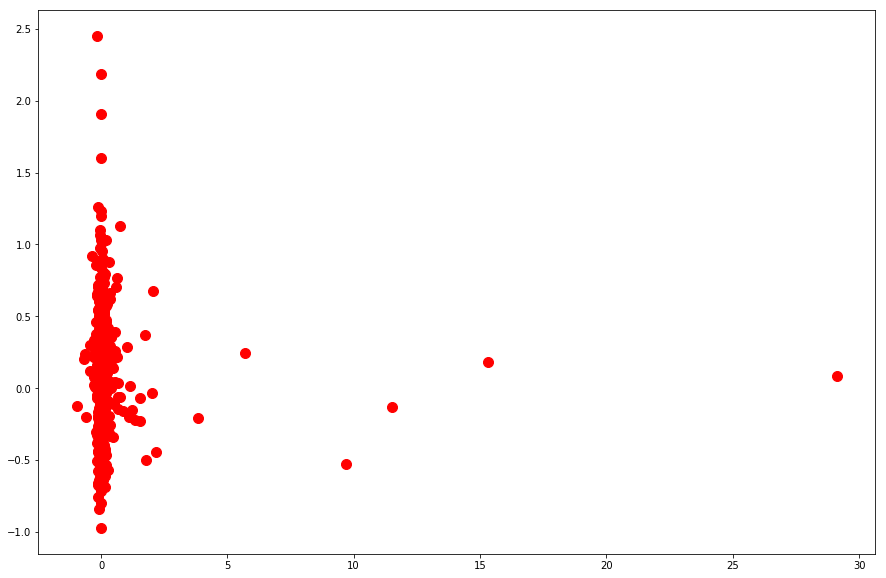

In [6]:
plt.scatter(dfrEmpStk_pct["EmpCount"], dfrEmpStk_pct["StkPrice"], s=100, c='red')

###### If percentage change doesn't make sense, it might be better to look at a standardized measure of change, such as standard deviation/ z-scores to evaluate if there is any correlation between the two. This is more likely to work better as it represents change from the mean rather than a value change period over period.

In [7]:
# Convert both datasets to z-scores.

# This function was needed since .apply(zscore, axis="index") was removing several companies' values.
# If there is a NaN for any datapoint in a column when calcing, the entire column is returned NaN.
# Performs columnwise conversion of a dataset to z-scores.
def zscores_calc(dfrData):
    dfrData_z = None
    for strcolumn in dfrData.columns:
        dsrTemp = dfrData[strcolumn]
        dsrTemp_z = (dsrTemp-dsrTemp.mean())/dsrTemp.std()
        if dfrData_z is None:
            dfrData_z = pd.DataFrame(dsrTemp_z)
        else:
            dfrData_z = pd.concat([dfrData_z, pd.DataFrame(dsrTemp_z)], axis=1)
    return dfrData_z

dfrEmpCount_z = zscores_calc(dfrEmpCount)
dfrStkPrice_z = zscores_calc(dfrStkPrice)
#dfrEmpCount_z = dfrEmpCount.apply(zscore, axis="index")
#dfrStkPrice_z = dfrStkPrice.apply(zscore, axis="index")
# Create flat versions of the datasets
dfrEmpCount_flt = dfrEmpCount_z.unstack()
dfrStkPrice_flt = dfrStkPrice_z.unstack()
dfrEmpCount_flt.name = "EmpCount"
dfrStkPrice_flt.name = "StkPrice"

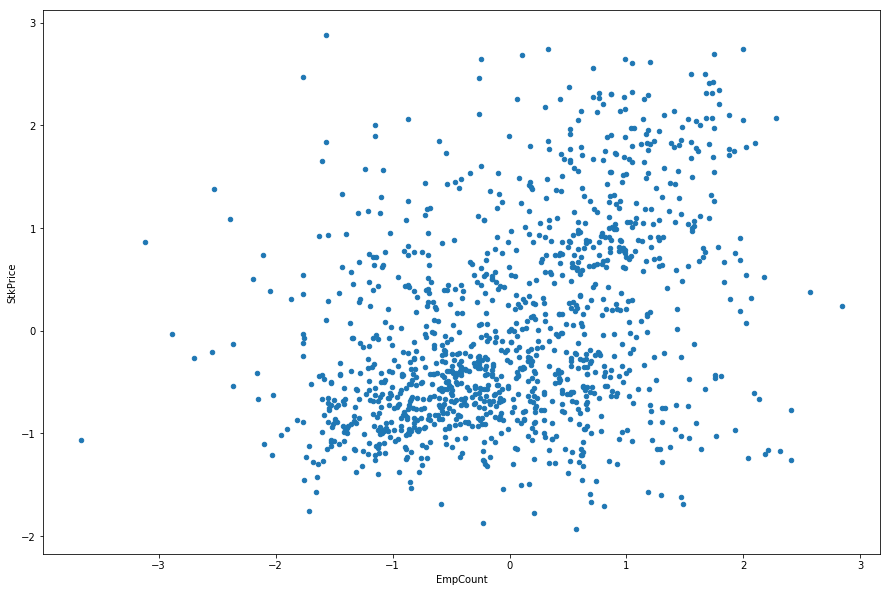

In [8]:
# Concatenate the two data series so they can be graphed together
dfrEmpStk_z = pd.concat([dfrEmpCount_flt, dfrStkPrice_flt], axis=1)
dfrEmpStk_z.plot.scatter(x="EmpCount", y="StkPrice")

###### There are some points clustered around the 45 degree axis indicating corelation but there is a huge amount of dispersion. It might be useful to filter to narrow down the outliers and where they are coming from.

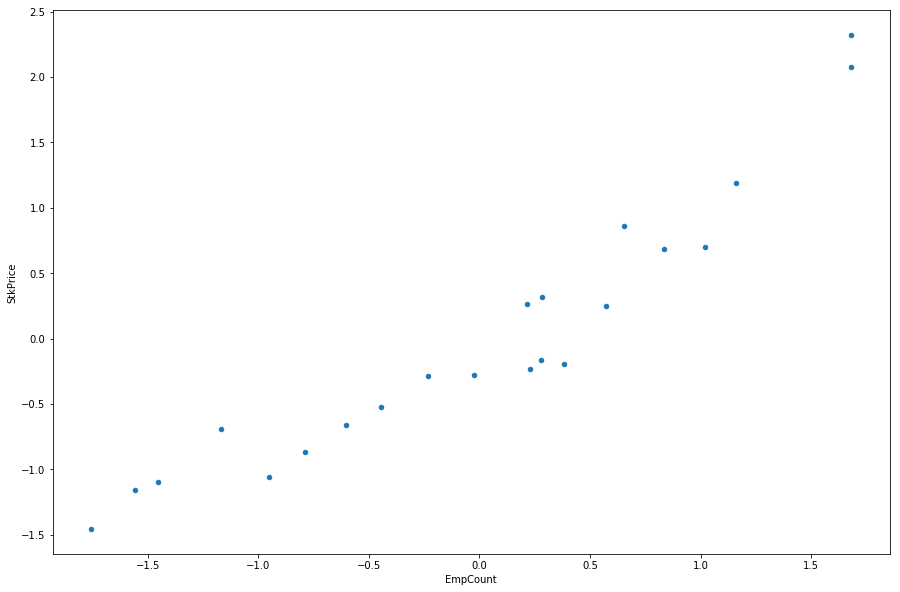

In [9]:
dfrEmpStk_z_filt = dfrEmpStk_z.loc["AFL"]
dfrEmpStk_z_filt.plot.scatter(x="EmpCount", y="StkPrice")

###### Well it worked for one company! (Specifically AFLAC Inc (AFL)) Let's try to differentiate the companies.

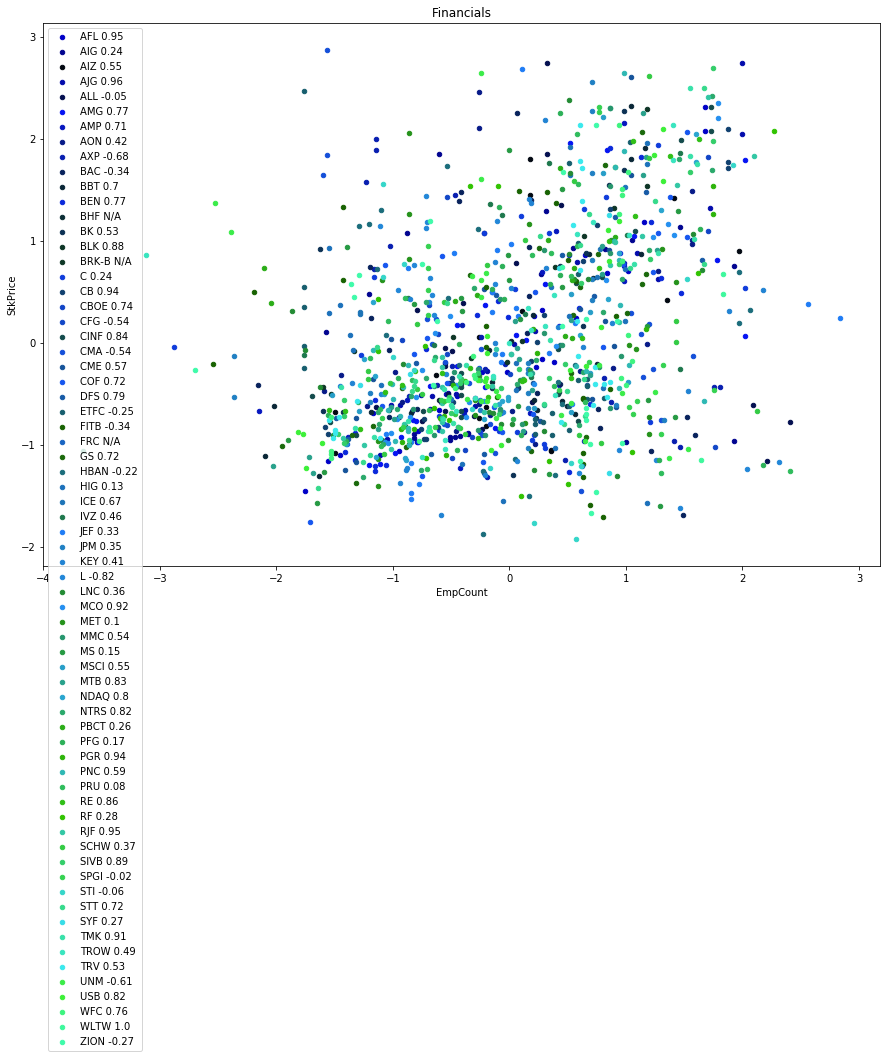

In [10]:
# Define function to plot a series of tickers on the same canvas with different colors.
def multitickers_plot(dfrData, lstFilters, strAnnotate=None, strTitle="", intSeed=75843754):
    random.seed(intSeed)
    fig, ax = plt.subplots()
    intTick_Cnt = len(lstFilters)
    varCorr = dfrData["StkPrice"].corr(dfrData["EmpCount"])
    if str(varCorr) != "nan":
        strLabel = strTitle + " " + str(varCorr.round(2))
    for intCounter, strTicker in enumerate(lstFilters):
        tupColor = ((intCounter*0.25)/intTick_Cnt, intCounter/intTick_Cnt, random.random())
        dfrSample = dfrData.loc[strTicker]
        # Calculate correlations for the specific ticker.
        varCorr = dfrSample["StkPrice"].corr(dfrSample["EmpCount"])
        if str(varCorr) != "nan":
            strLabel = strTicker + " " + str(varCorr.round(2))
        else:
            strLabel = strTicker + " N/A"
        ax = dfrSample.plot.scatter(x="EmpCount", y="StkPrice", color=tupColor, label=strLabel, title=strTitle, ax=ax)
        # Annotate the year or the ticker to each plot point to make it easier to identify series.
        if strAnnotate == "Year":
            for k, v in dfrSample.iterrows():
                ax.annotate(k.strftime("%Y"), v)
        elif strAnnotate == "Ticker":
            for k, v in dfrSample.iterrows():
                ax.annotate(strTicker, v)
    fig.canvas.draw()
lstTickers = dfrEmpStk_z.index.get_level_values(0).unique()
multitickers_plot(dfrEmpStk_z, lstTickers, strTitle="Financials")


###### Still too much to look at, so maybe differentiating by sub industry will be easier.

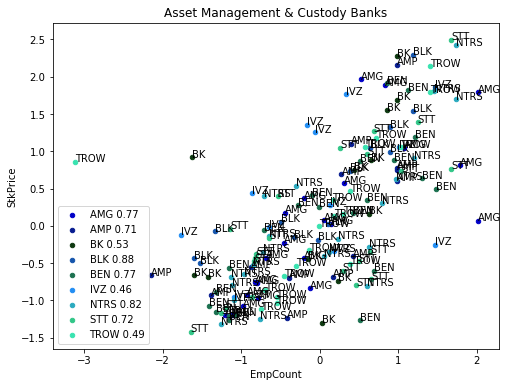

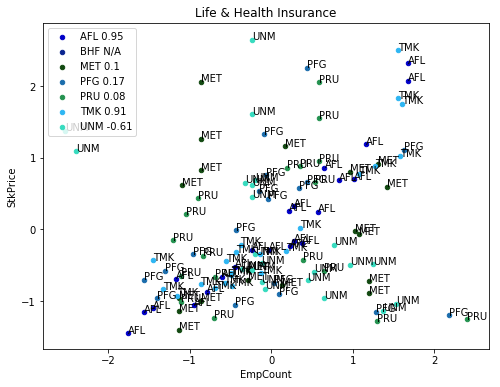

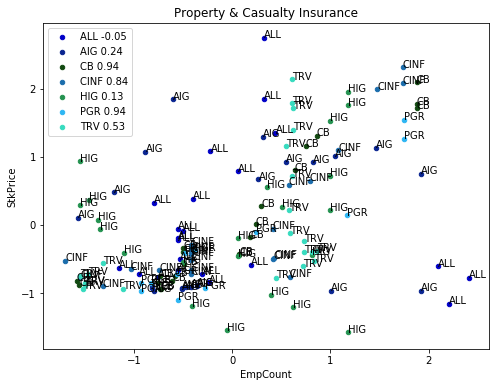

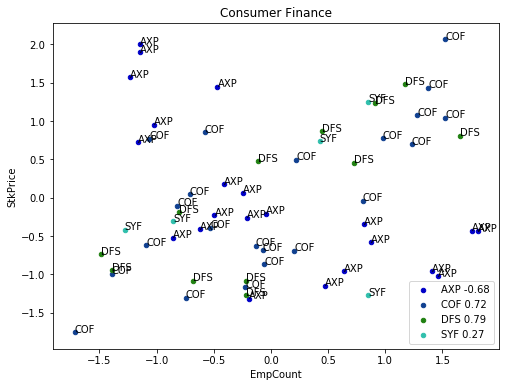

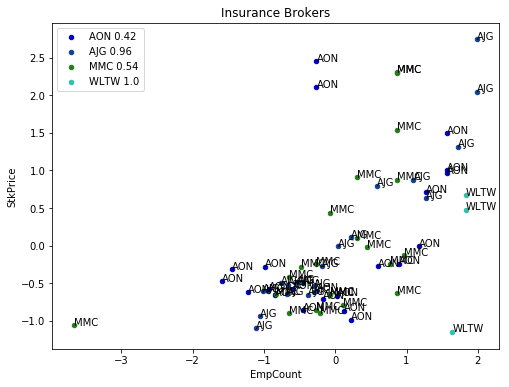

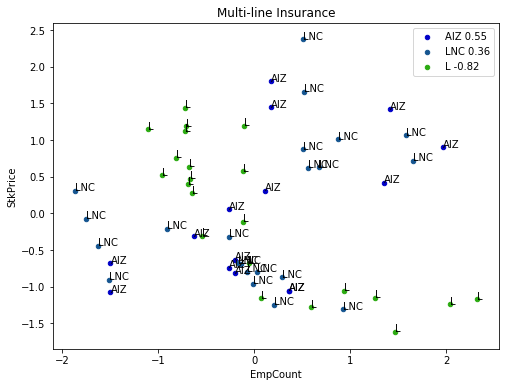

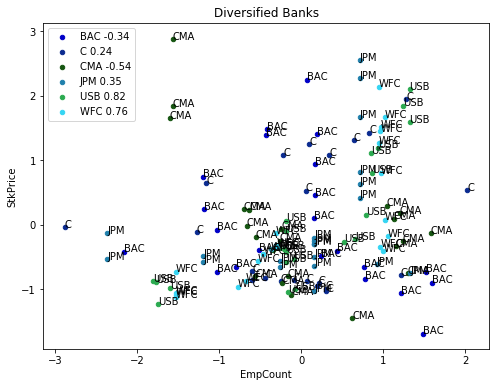

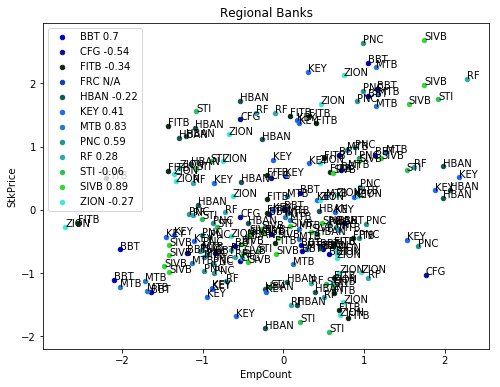

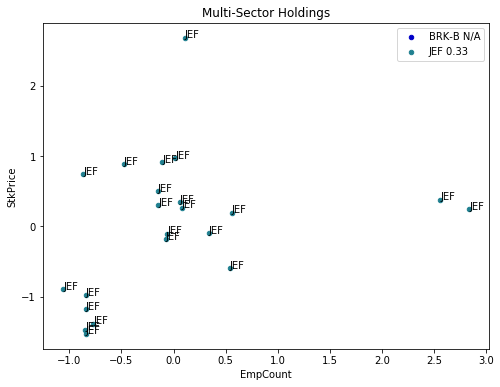

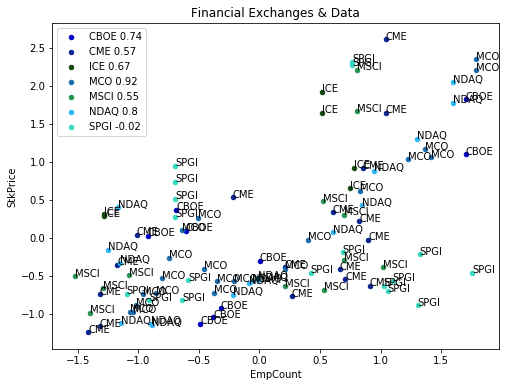

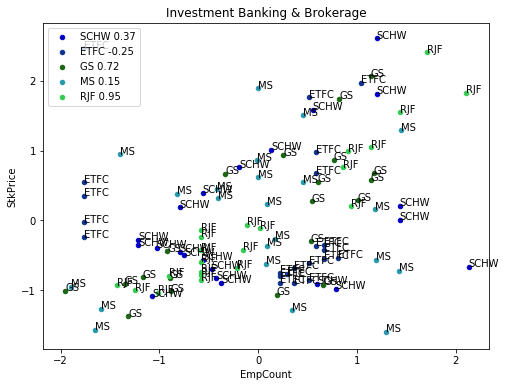

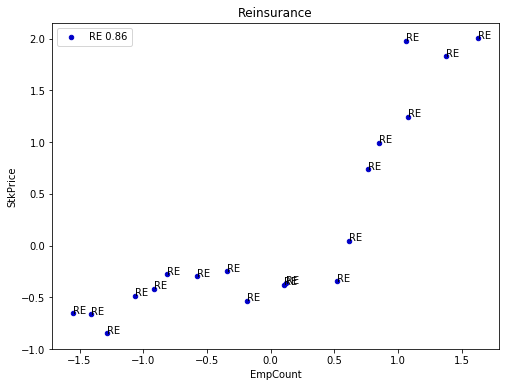

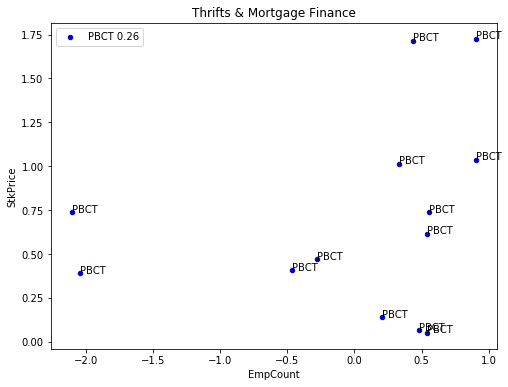

In [11]:
# First, let's filter the list of constituents down for data we have. Then let's plot by GICS sub-industry.
matplotlib.rcParams['figure.figsize'] = [8, 6]
def subindustry_plot(dfrData, strSubIndustry):
    lstTickers = dfrConstituents[dfrConstituents["GICS Sub Industry"] == strSubIndustry]["Symbol"].tolist()
    dfrData_filt = dfrData[dfrData.index.get_level_values(0).isin(lstTickers)]
    multitickers_plot(dfrData_filt, lstTickers, strAnnotate="Ticker", strTitle=strSubIndustry)

# Get a list of all the tickers z-score data is available.
lstTickers = dfrEmpStk_z.index.get_level_values(0).unique().tolist()

# Plot all the sub industries in Financials.
dfrConstituents = dfrConstituents[dfrConstituents["Symbol"].isin(lstTickers)]
lstSubIndustry = dfrConstituents["GICS Sub Industry"].unique()
for strSubIndustry in lstSubIndustry:
    subindustry_plot(dfrEmpStk_z, strSubIndustry)


###### From the above, it looks like there is a strong amount of correlation for some companies, but others have poor correlation. The question is what differentiates them. There are three possibilities:
1. There may be a common factor amongst those companies or a large number of them that cause them to react that way.
2. Idiosyncratic factors exist for each of those companies that may cause correlation to be low. An example is Bank of America's (BAC) merger with Merrill Lynch increased employee size but caused the stock price to plummet.
3. The correlation is simply coincidental across all companies.

###### Each of these need to be explored, with the first two hypotheses capable of invalidating the last.